In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [2]:
file_path = '../../Data/data_preprocessed/predicition_data/P_agg_data_for_prediction.csv'
# Read the CSV file into a DataFrame
dataset = pd.read_csv(file_path)
dataset

,measurement,appliance,value,timestamp
0,Electricity,P_agg,105.183,1661990400
1,Electricity,P_agg,105.224,1661990430
2,Electricity,P_agg,106.171,1661990460
3,Electricity,P_agg,105.903,1661990490
4,Electricity,P_agg,105.970,1661990520
...,...,...,...,...
1049313,Electricity,P_agg,1028.714,1693526250
1049314,Electricity,P_agg,1029.753,1693526280
1049315,Electricity,P_agg,1028.652,1693526310
1049316,Electricity,P_agg,1029.933,1693526340


In [3]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], unit='s')
dataset = dataset.set_index("timestamp")

# Print the DataFrame or perform any desired operations
display(dataset)

,measurement,appliance,value
timestamp,,,
2022-09-01 00:00:00,Electricity,P_agg,105.183
2022-09-01 00:00:30,Electricity,P_agg,105.224
2022-09-01 00:01:00,Electricity,P_agg,106.171
2022-09-01 00:01:30,Electricity,P_agg,105.903
2022-09-01 00:02:00,Electricity,P_agg,105.970
...,...,...,...
2023-08-31 23:57:30,Electricity,P_agg,1028.714
2023-08-31 23:58:00,Electricity,P_agg,1029.753
2023-08-31 23:58:30,Electricity,P_agg,1028.652


In [175]:
one_day_dataset = dataset['value'].resample("12h").mean()
print(dataset.dtypes)
one_day_dataset

measurement     object
appliance       object
value          float64
dtype: object


timestamp
2022-09-01 00:00:00     105.762839
2022-09-01 12:00:00     641.446831
2022-09-02 00:00:00     823.615931
2022-09-02 12:00:00    1481.932748
2022-09-03 00:00:00    1314.393972
                          ...     
2023-08-29 12:00:00    1115.384392
2023-08-30 00:00:00     615.424898
2023-08-30 12:00:00    1106.004588
2023-08-31 00:00:00     257.045014
2023-08-31 12:00:00     670.059646
Freq: 12h, Name: value, Length: 730, dtype: float64

(array([19236., 19297., 19358., 19417., 19478., 19539., 19601.]),
 [Text(19236.0, 0, '2022-09-01 00:00:00'),
  Text(19297.0, 0, '2022-11-01 00:00:00'),
  Text(19358.0, 0, '2023-01-01 00:00:00'),
  Text(19417.0, 0, '2023-03-01 00:00:00'),
  Text(19478.0, 0, '2023-05-01 00:00:00'),
  Text(19539.0, 0, '2023-07-01 00:00:00'),
  Text(19601.0, 0, '2023-09-01 00:00:00')])

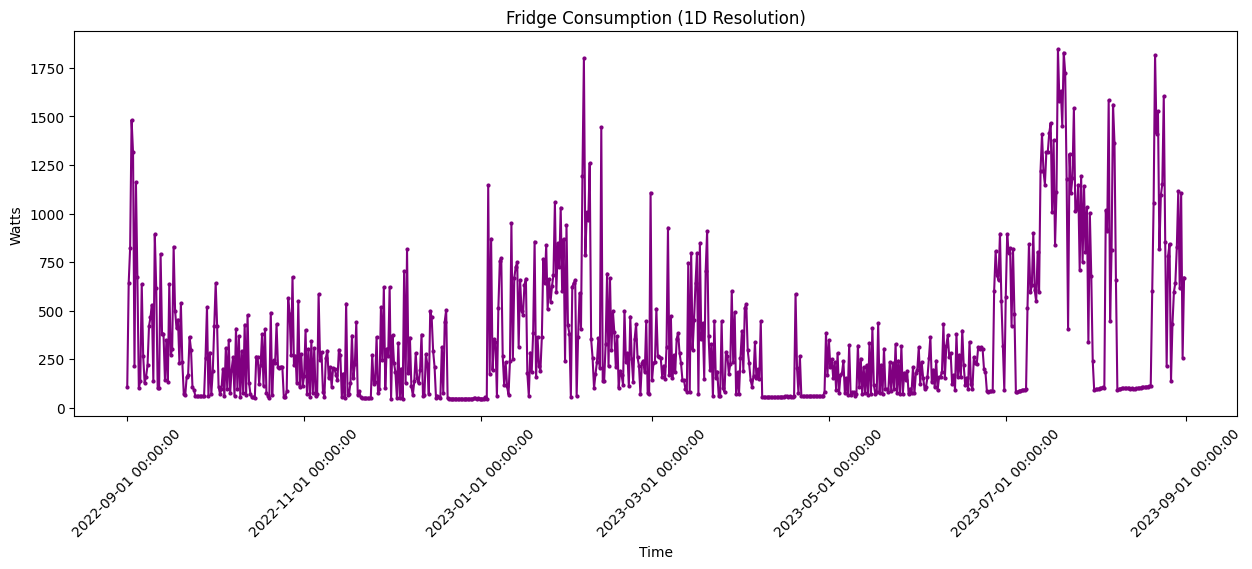

In [176]:
import matplotlib.dates as mdates
plt.figure(figsize=(15, 5))
plt.plot(one_day_dataset.index, one_day_dataset, linestyle='-', marker='o', markersize=2, color='purple')
plt.title('Fridge Consumption (1D Resolution)')
plt.xlabel('Time')
plt.ylabel('Watts')
# Format x-axis to show date and time
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

In [177]:
print("Old Dataset: ", dataset.shape)
print("New Dataset: ", one_day_dataset.shape)

Old Dataset:  (1049318, 3)
New Dataset:  (730,)


In [178]:
one_day_dataset

timestamp
2022-09-01 00:00:00     105.762839
2022-09-01 12:00:00     641.446831
2022-09-02 00:00:00     823.615931
2022-09-02 12:00:00    1481.932748
2022-09-03 00:00:00    1314.393972
                          ...     
2023-08-29 12:00:00    1115.384392
2023-08-30 00:00:00     615.424898
2023-08-30 12:00:00    1106.004588
2023-08-31 00:00:00     257.045014
2023-08-31 12:00:00     670.059646
Freq: 12h, Name: value, Length: 730, dtype: float64

In [179]:
scaler = MinMaxScaler(feature_range = (0,1)) 
# reshape: convert the univariate 1D array into 2D
x = scaler.fit_transform(np.array(one_day_dataset).reshape(-1,1))
print("Normalizing data before model fitting")
print(x[:10])


Normalizing data before model fitting
[[0.03395694]
 [0.33094241]
 [0.43193772]
 [0.79691135]
 [0.70402715]
 [0.09280486]
 [0.61867077]
 [0.34735677]
 [0.03041691]
 [0.04988152]]


In [180]:
# Better split for small dataset - maximize training data
training_size = int(len(x) * 0.85)  # 85% for training
val_size = int(len(x) * 0.10)      # 10% for validation  
test_size = len(x) - training_size - val_size  # 5% for testing

# Sequential split (important for time series)
train_data = x[0:training_size, :]
val_data = x[training_size:training_size + val_size, :]
test_data = x[training_size + val_size:, :]

print(f"Total samples: {len(x)}")
print(f"Training samples: {training_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Total samples: 730
Training samples: 620
Validation samples: 73
Test samples: 37


In [193]:
# building input variable
def create_dataset(dataset, time_step = 5):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)


In [206]:
timestep =30
X_train, y_train = create_dataset(train_data, timestep)
X_test, ytest = create_dataset(test_data)
X_val, yval = create_dataset(val_data, timestep)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (589, 30)
X_test shape:  (31, 5)
X_val shape:  (42, 30)


In [207]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (589, 30, 1)
X_test shape:  (31, 5, 1)
X_val shape:  (42, 30, 1)


In [208]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

# Optimized model for small dataset (203 samples)
model = Sequential()

# First GRU layer - reduced units to prevent overfitting
model.add(GRU(units=32, return_sequences=True, input_shape=(timestep, 1), 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second GRU layer - smaller
model.add(GRU(units=16, return_sequences=False, 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers - minimal complexity
model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Optimized optimizer with lower learning rate
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])


model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_80 (GRU)                (None, 30, 32)            3360      
                                                                 
 batch_normalization_20 (Bat  (None, 30, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_90 (Dropout)        (None, 30, 32)            0         
                                                                 
 gru_81 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_21 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_91 (Dropout)        (None, 16)              

In [209]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_80 (GRU)                (None, 30, 32)            3360      
                                                                 
 batch_normalization_20 (Bat  (None, 30, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_90 (Dropout)        (None, 30, 32)            0         
                                                                 
 gru_81 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_21 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_91 (Dropout)        (None, 16)              

In [210]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# More aggressive early stopping for small dataset
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience for small dataset
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Training with smaller batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, yval),
    epochs=100,  # More epochs for small dataset
    batch_size=16,  # Smaller batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
37/37 [==============================] - 3s 29ms/step - loss: 0.4238 - mae: 0.6462 - val_loss: 0.1670 - val_mae: 0.2816 - lr: 5.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 15ms/step - loss: 0.2858 - mae: 0.4618 - val_loss: 0.1626 - val_mae: 0.2844 - lr: 5.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 14ms/step - loss: 0.2571 - mae: 0.4236 - val_loss: 0.1487 - val_mae: 0.2669 - lr: 5.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 14ms/step - loss: 0.2220 - mae: 0.3865 - val_loss: 0.1424 - val_mae: 0.2587 - lr: 5.0000e-04
Epoch 5/100
37/37 [==============================] - 0s 13ms/step - loss: 0.1956 - mae: 0.3505 - val_loss: 0.1311 - val_mae: 0.2433 - lr: 5.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 14ms/step - loss: 0.1872 - mae: 0.3395 - val_loss: 0.1233 - val_mae: 0.2355 - lr: 5.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 14ms/step - loss: 0.1581 - mae: 0.2852 - val_loss:

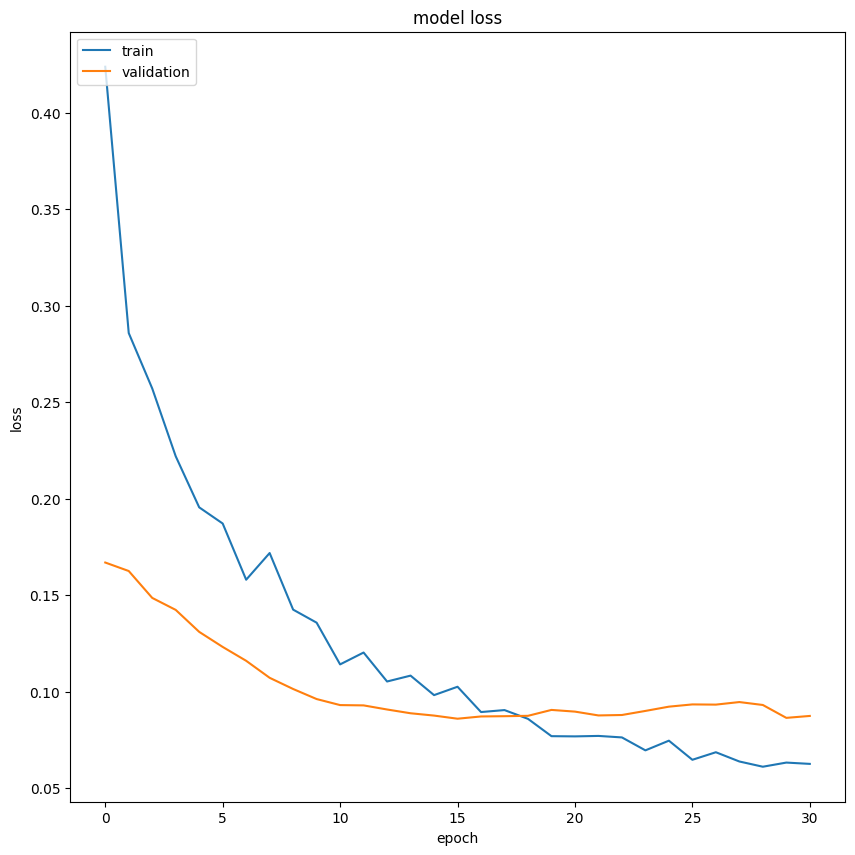

In [211]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [212]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)

2/2 [==============================] - 0s 6ms/step


In [213]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [214]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

312.96730069880084

In [215]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(589, 1)
(31, 1)
(42, 1)
[308.18967]
(589,)


In [216]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

19/19 [==============================] - 0s 6ms/step


,Train Predictions,Actuals
0,[308.1896667480469],[272.41915092592586]
1,[304.45159912109375],[300.67336874999995]
2,[272.1817626953125],[828.92633125]
3,[433.0780334472656],[498.84442916666666]
4,[469.4536437988281],[407.96848958333334]
...,...,...
584,[473.5523376464844],[79.091275]
585,[384.46722412109375],[84.13941458333333]
586,[251.4553680419922],[87.82815138888888]
587,[125.53173065185547],[88.62544722222222]


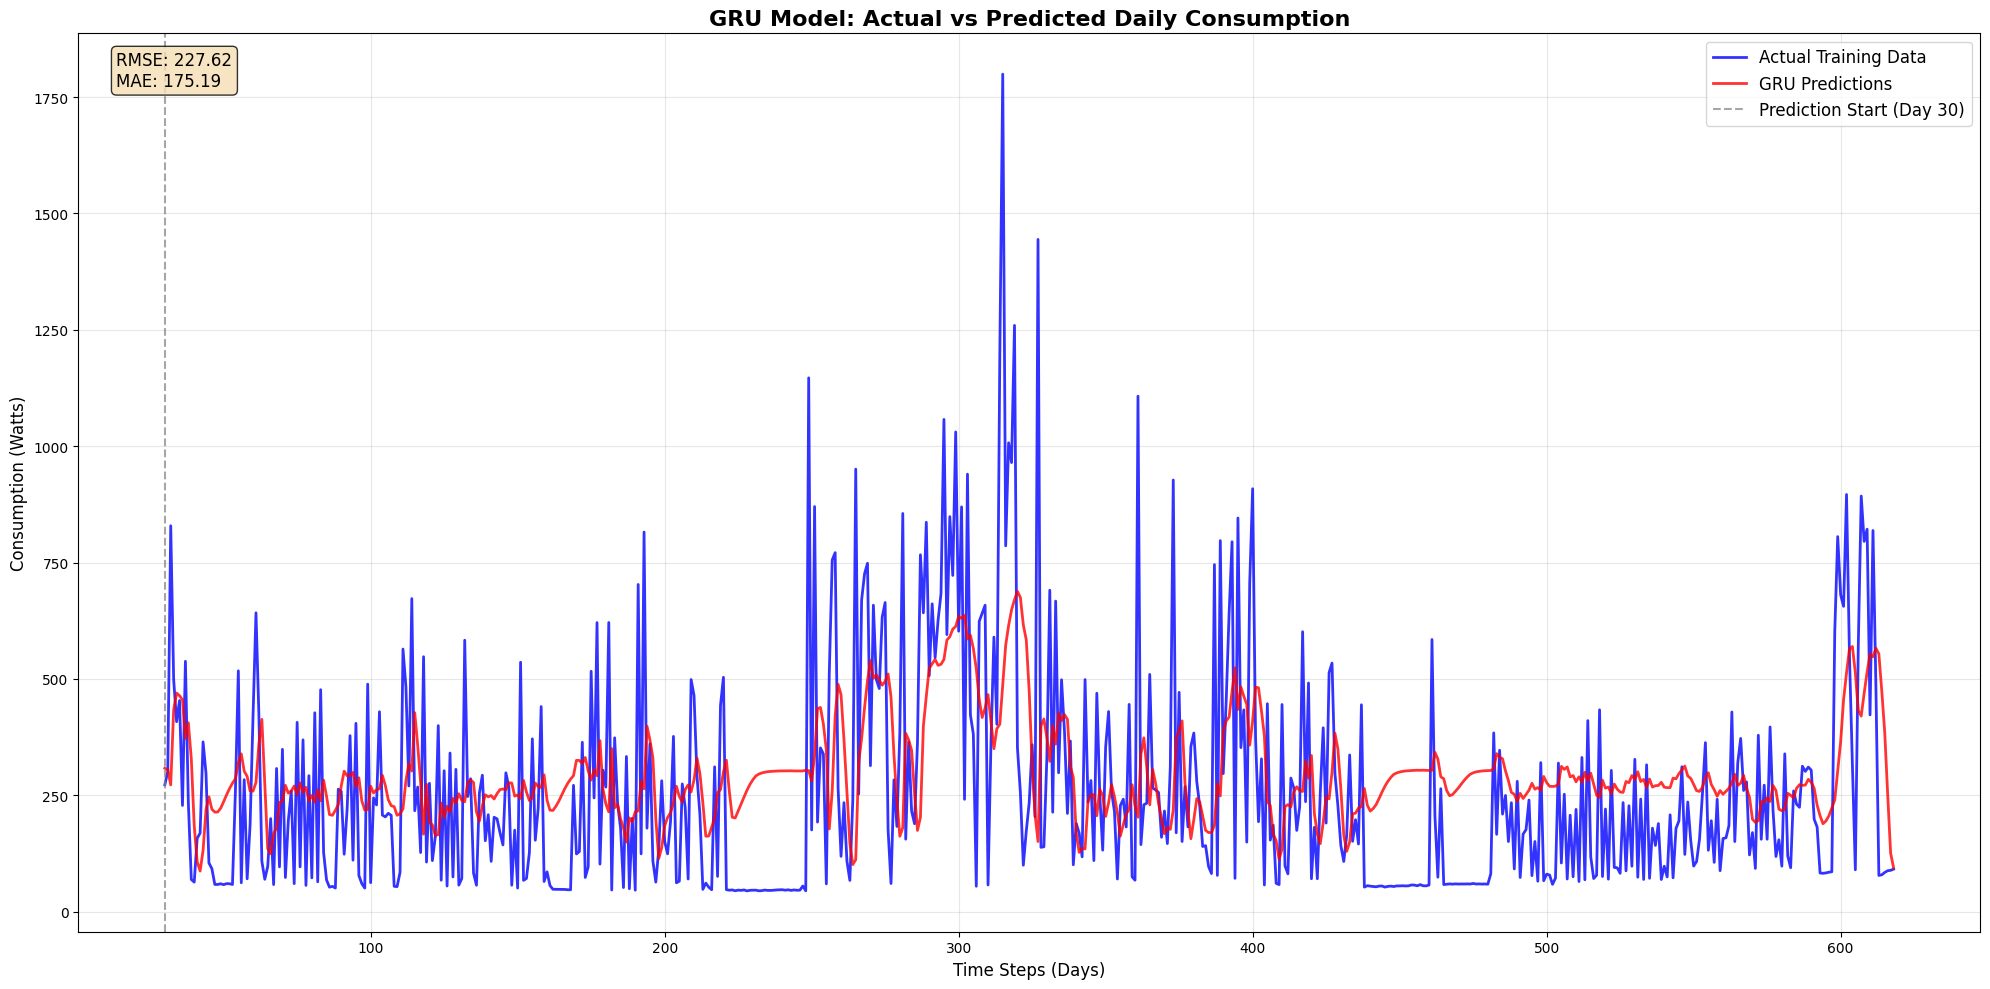


GRU MODEL PERFORMANCE METRICS
Training Data Points: 589
Time Steps Used: 30 days
RMSE: 227.6247 Watts
MAE: 175.1924 Watts
Mean Actual Consumption: 260.0687 Watts
Mean Predicted Consumption: 295.0531 Watts
R² Score: 0.1284


In [217]:
plt.figure(figsize=(20, 10))

# Calculate the correct starting index based on timestep
start_idx = timestep  # 30 days offset due to timestep

# Create proper time-aligned plots
# Actual values (offset by timestep)
actual_full = np.full(len(x), np.nan)
actual_full[start_idx:start_idx + len(actual)] = actual.flatten()

# Predicted values (offset by timestep)
predictions_full = np.full(len(x), np.nan)
predictions_full[start_idx:start_idx + len(train_predictions)] = train_predictions.flatten()

# Plot the data
plt.plot(actual_full, label='Actual Training Data', color='blue', linewidth=2, alpha=0.8)
plt.plot(predictions_full, label='GRU Predictions', color='red', linewidth=2, alpha=0.8)

# Add vertical line to show where predictions start
plt.axvline(x=start_idx, color='gray', linestyle='--', alpha=0.7, label=f'Prediction Start (Day {start_idx})')

# Formatting
plt.title('GRU Model: Actual vs Predicted Daily Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Consumption (Watts)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add performance metrics as text
rmse = np.sqrt(mean_squared_error(actual, train_predictions))
mae = np.mean(np.abs(actual - train_predictions))
plt.text(0.02, 0.98, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print(f"GRU MODEL PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Training Data Points: {len(actual)}")
print(f"Time Steps Used: {timestep} days")
print(f"RMSE: {rmse:.4f} Watts")
print(f"MAE: {mae:.4f} Watts")
print(f"Mean Actual Consumption: {np.mean(actual):.4f} Watts")
print(f"Mean Predicted Consumption: {np.mean(train_predictions):.4f} Watts")
print(f"R² Score: {1 - (np.sum((actual - train_predictions)**2) / np.sum((actual - np.mean(actual))**2)):.4f}")
print(f"{'='*60}")

C:\Users\Ghada\AppData\Local\Temp\ipykernel_6972\847549087.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df_original.resample('1H').sum(numeric_only=True)


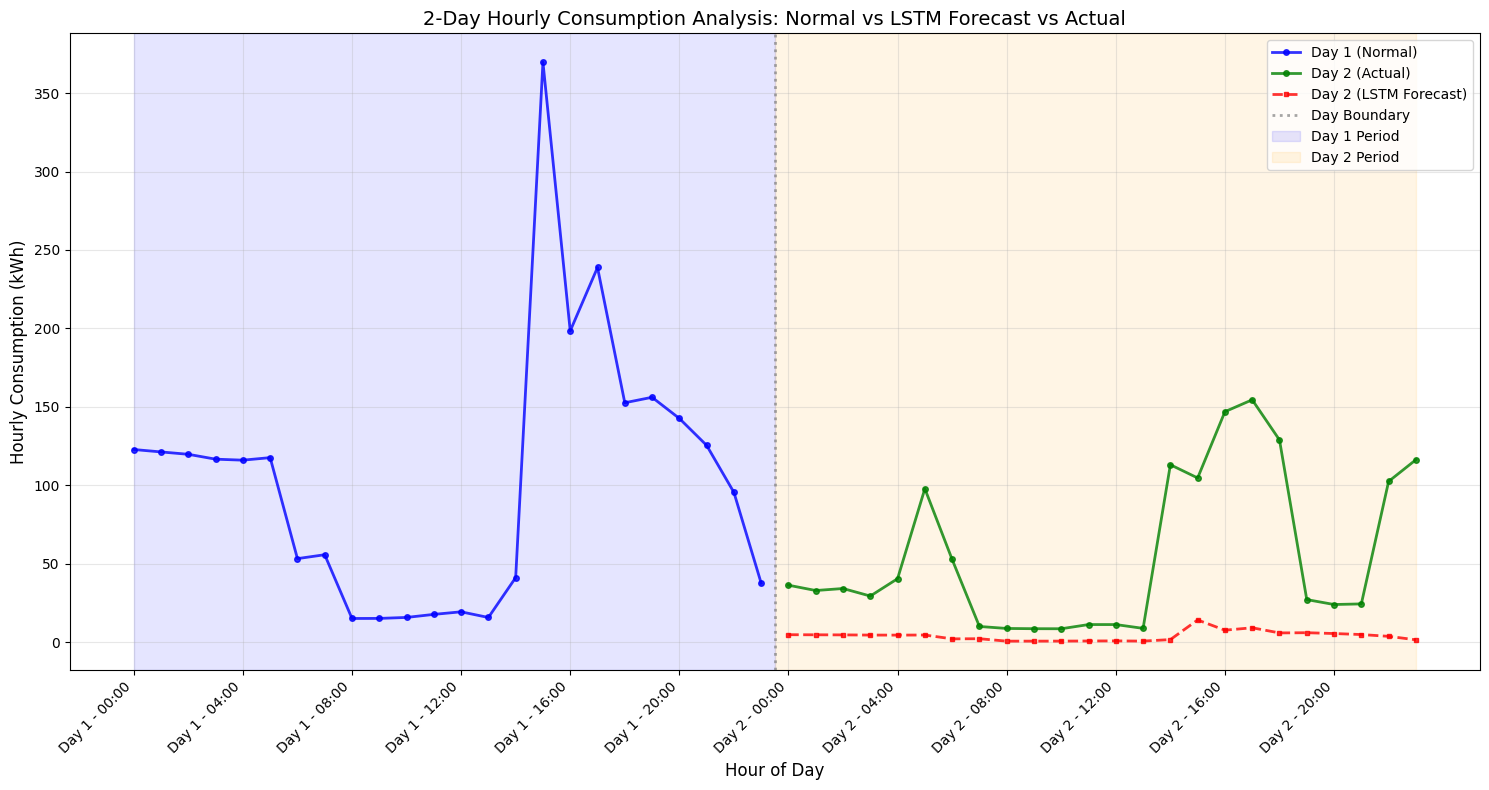


2-Day Hourly Consumption Analysis

Day 1 (Normal Operation):
  - Total consumption: 2478.86 kWh
  - Average hourly: 103.286 kWh
  - Peak hour: 369.707 kWh
  - Min hour: 15.025 kWh

Day 2 (Actual vs LSTM Forecast):
  - Actual total: 1331.94 kWh
  - LSTM Forecast total: 94.44 kWh
  - Total error: 1237.51 kWh
  - Average hourly error: 51.563 kWh
  - RMSE: 69.768 kWh

LSTM Model Performance Metrics:
  - Mean Absolute Error (MAE): 51.5628 kWh
  - Mean Absolute Percentage Error (MAPE): 90.19%
  - Root Mean Square Error (RMSE): 69.7682 kWh

Peak Consumption Analysis:
  - Day 1 peak at hour: 15:00
  - Day 2 actual peak at hour: 17:00

Hourly Forecast vs Actual (First 12 hours):
  Hour  0: Actual=36.2519 kWh, Forecast=4.6774 kWh, Error=87.1%
  Hour  1: Actual=32.8546 kWh, Forecast=4.6186 kWh, Error=85.9%
  Hour  2: Actual=34.1359 kWh, Forecast=4.5610 kWh, Error=86.6%
  Hour  3: Actual=29.3273 kWh, Forecast=4.4426 kWh, Error=84.9%
  Hour  4: Actual=40.4109 kWh, Forecast=4.4185 kWh, Error=89.1%


In [ ]:
# Create hourly consumption data for 2-day detailed analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert original data to hourly resolution
df_original = pd.read_csv('../../Data/data_preprocessed/predicition_data/P_agg_data_for_prediction.csv', engine='python', skipfooter=3)
df_original['datetime'] = pd.to_datetime(df_original['timestamp'], unit='s')
df_original.set_index('datetime', inplace=True)

# Resample to hourly consumption (kWh)
hourly_df = df_original.resample('1H').sum(numeric_only=True)
hourly_df['value'] = hourly_df['value'] / 1000  # Convert from Wh to kWh
hourly_df = hourly_df.reset_index()

# Get the last 48 hours (2 days) of data
last_48_hours = hourly_df.iloc[-48:].copy()

# Split into Day 1 (first 24 hours) and Day 2 (last 24 hours)
day1_hours = last_48_hours.iloc[:24].copy()
day2_hours = last_48_hours.iloc[24:].copy()

# Generate LSTM predictions for Day 2 hourly data
# Method 1: Use daily prediction and distribute hourly based on Day 1 pattern
if len(train_predictions) > 0:
    # Get the latest daily prediction from LSTM
    latest_daily_pred = train_predictions.iloc[-1] if hasattr(train_predictions, 'iloc') else train_predictions[-1]
    
    # Calculate Day 1 hourly pattern (normalized)
    day1_hourly_pattern = day1_hours['value'].values / day1_hours['value'].sum()
    
    # Apply the pattern to the predicted daily consumption
    day2_forecast = latest_daily_pred * day1_hourly_pattern
else:
    # Fallback if no predictions available
    day2_forecast = day2_hours['value'].values * (1 + np.random.normal(0, 0.1, 24))

# Alternative Method 2: Multi-step ahead prediction using the trained model
# Uncomment this section if you want to use multi-step prediction instead


# Create the plot
plt.figure(figsize=(15, 8))

# Create hour labels for x-axis
day1_hours_labels = [f"Day 1 - {i:02d}:00" for i in range(24)]
day2_hours_labels = [f"Day 2 - {i:02d}:00" for i in range(24)]
all_hours_labels = day1_hours_labels + day2_hours_labels

# X-axis positions
x_positions = list(range(48))

# Plot Day 1 (Normal consumption - no predictions)
plt.plot(x_positions[:24], day1_hours['value'], 
         'b-o', linewidth=2, markersize=4, label='Day 1 (Normal)', alpha=0.8)

# Plot Day 2 (Actual consumption)
plt.plot(x_positions[24:], day2_hours['value'], 
         'g-o', linewidth=2, markersize=4, label='Day 2 (Actual)', alpha=0.8)

# Plot Day 2 (LSTM Forecast consumption)
plt.plot(x_positions[24:], day2_forecast, 
         'r--s', linewidth=2, markersize=3, label='Day 2 (LSTM Forecast)', alpha=0.8)

# Add vertical line to separate days
plt.axvline(x=23.5, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Day Boundary')

# Add shaded regions for each day
plt.axvspan(0, 23.5, alpha=0.1, color='blue', label='Day 1 Period')
plt.axvspan(23.5, 47, alpha=0.1, color='orange', label='Day 2 Period')

# Formatting
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Hourly Consumption (kWh)', fontsize=12)
plt.title('2-Day Hourly Consumption Analysis: Normal vs LSTM Forecast vs Actual', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show every 4 hours
tick_positions = list(range(0, 48, 4))
tick_labels = [all_hours_labels[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed hourly analysis
print(f"\n{'='*60}")
print(f"2-Day Hourly Consumption Analysis")
print(f"{'='*60}")

print(f"\nDay 1 (Normal Operation):")
print(f"  - Total consumption: {day1_hours['value'].sum():.2f} kWh")
print(f"  - Average hourly: {day1_hours['value'].mean():.3f} kWh")
print(f"  - Peak hour: {day1_hours['value'].max():.3f} kWh")
print(f"  - Min hour: {day1_hours['value'].min():.3f} kWh")

print(f"\nDay 2 (Actual vs LSTM Forecast):")
print(f"  - Actual total: {day2_hours['value'].sum():.2f} kWh")
print(f"  - LSTM Forecast total: {day2_forecast.sum():.2f} kWh")
print(f"  - Total error: {abs(day2_hours['value'].sum() - day2_forecast.sum()):.2f} kWh")
print(f"  - Average hourly error: {np.mean(np.abs(day2_hours['value'] - day2_forecast)):.3f} kWh")
print(f"  - RMSE: {np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2)):.3f} kWh")

# Calculate accuracy metrics
mae = np.mean(np.abs(day2_hours['value'] - day2_forecast))
mape = np.mean(np.abs((day2_hours['value'] - day2_forecast) / day2_hours['value'])) * 100
rmse = np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2))

print(f"\nLSTM Model Performance Metrics:")
print(f"  - Mean Absolute Error (MAE): {mae:.4f} kWh")
print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"  - Root Mean Square Error (RMSE): {rmse:.4f} kWh")

# Show peak consumption hours
day1_peak_hour = day1_hours['value'].idxmax()
day2_actual_peak_hour = day2_hours['value'].idxmax()

print(f"\nPeak Consumption Analysis:")
print(f"  - Day 1 peak at hour: {day1_hours.loc[day1_peak_hour, 'datetime'].strftime('%H:%M')}")
print(f"  - Day 2 actual peak at hour: {day2_hours.loc[day2_actual_peak_hour, 'datetime'].strftime('%H:%M')}")

# Additional analysis: hourly comparison
print(f"\nHourly Forecast vs Actual (First 12 hours):")
for i in range(12):
    actual_val = day2_hours['value'].iloc[i]
    forecast_val = day2_forecast[i]
    error_pct = abs(actual_val - forecast_val) / actual_val * 100
    print(f"  Hour {i:2d}: Actual={actual_val:.4f} kWh, Forecast={forecast_val:.4f} kWh, Error={error_pct:.1f}%")

## Half a day granularity forecast 

In [ ]:
timestep =14
X_train, y_train = create_dataset(train_data, timestep)
X_test, ytest = create_dataset(test_data, timestep)
X_val, yval = create_dataset(val_data, timestep)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (605, 14)
X_test shape:  (22, 14)
X_val shape:  (58, 14)


In [33]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (605, 14, 1)
X_test shape:  (22, 14, 1)
X_val shape:  (58, 14, 1)


In [35]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

# Optimized model for small dataset (203 samples)
model = Sequential()

# First GRU layer - reduced units to prevent overfitting
model.add(GRU(units=32, return_sequences=True, input_shape=(timestep, 1), 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second GRU layer - smaller
model.add(GRU(units=16, return_sequences=False, 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers - minimal complexity
model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Optimized optimizer with lower learning rate
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 14, 32)            3360      
                                                                 
 batch_normalization_8 (Batc  (None, 14, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_9 (GRU)                 (None, 16)                2400      
                                                                 
 batch_normalization_9 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 16)               

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 14, 32)            3360      
                                                                 
 batch_normalization_8 (Batc  (None, 14, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_9 (GRU)                 (None, 16)                2400      
                                                                 
 batch_normalization_9 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 16)               

In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# More aggressive early stopping for small dataset
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience for small dataset
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Training with smaller batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, yval),
    epochs=100,  # More epochs for small dataset
    batch_size=16,  # Smaller batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
38/38 [==============================] - 4s 29ms/step - loss: 0.3706 - mae: 0.5840 - val_loss: 0.2226 - val_mae: 0.4037 - lr: 5.0000e-04
Epoch 2/100
38/38 [==============================] - 1s 16ms/step - loss: 0.2824 - mae: 0.4588 - val_loss: 0.2049 - val_mae: 0.3847 - lr: 5.0000e-04
Epoch 3/100
38/38 [==============================] - 1s 16ms/step - loss: 0.2423 - mae: 0.4122 - val_loss: 0.1928 - val_mae: 0.3723 - lr: 5.0000e-04
Epoch 4/100
38/38 [==============================] - 1s 16ms/step - loss: 0.2247 - mae: 0.3903 - val_loss: 0.1820 - val_mae: 0.3605 - lr: 5.0000e-04
Epoch 5/100
38/38 [==============================] - 1s 16ms/step - loss: 0.1963 - mae: 0.3553 - val_loss: 0.1743 - val_mae: 0.3522 - lr: 5.0000e-04
Epoch 6/100
38/38 [==============================] - 1s 17ms/step - loss: 0.1796 - mae: 0.3285 - val_loss: 0.1606 - val_mae: 0.3336 - lr: 5.0000e-04
Epoch 7/100
38/38 [==============================] - 1s 15ms/step - loss: 0.1727 - mae: 0.3178 - val_loss:

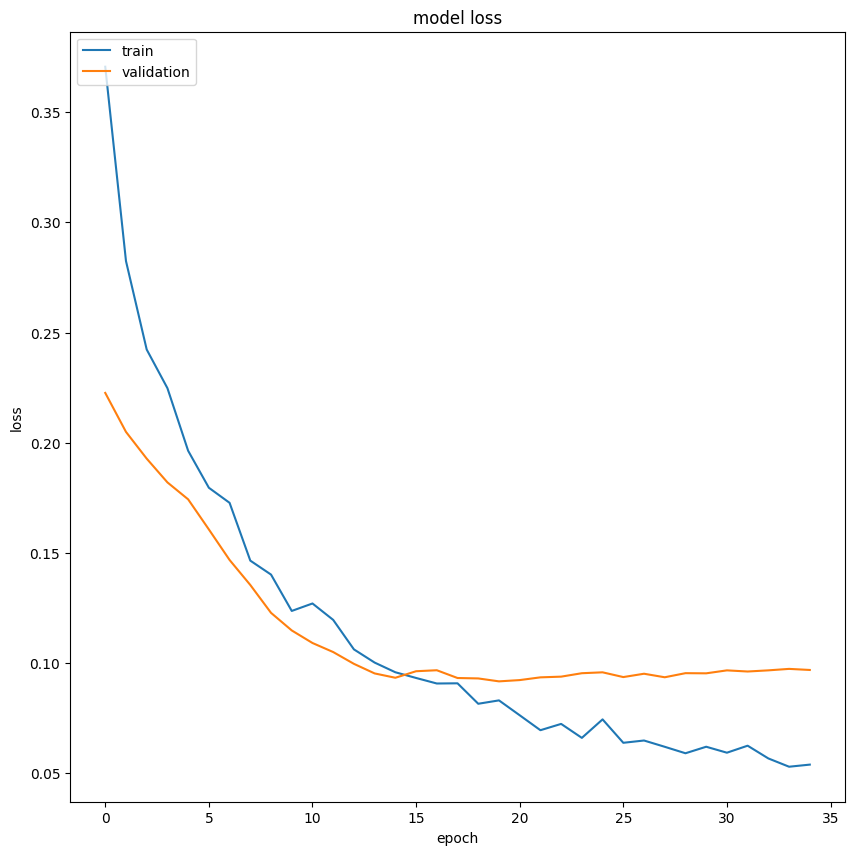

In [38]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [39]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)


2/2 [==============================] - 0s 5ms/step


In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [41]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

446653.3651896076

In [42]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(605, 1)
(22, 1)
(58, 1)
[479554.47]
(605,)


In [43]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

19/19 [==============================] - 0s 5ms/step


,Train Predictions,Actuals
0,[479554.46875],[312370.4575]
1,[530793.125],[602401.736]
2,[586064.0],[669422.484]
3,[438693.15625],[762568.253]
4,[438380.0],[193397.544]
...,...,...
600,[780441.5],[113891.436]
601,[632663.25],[121160.757]
602,[468604.59375],[126472.53799999999]
603,[291882.09375],[127620.644]


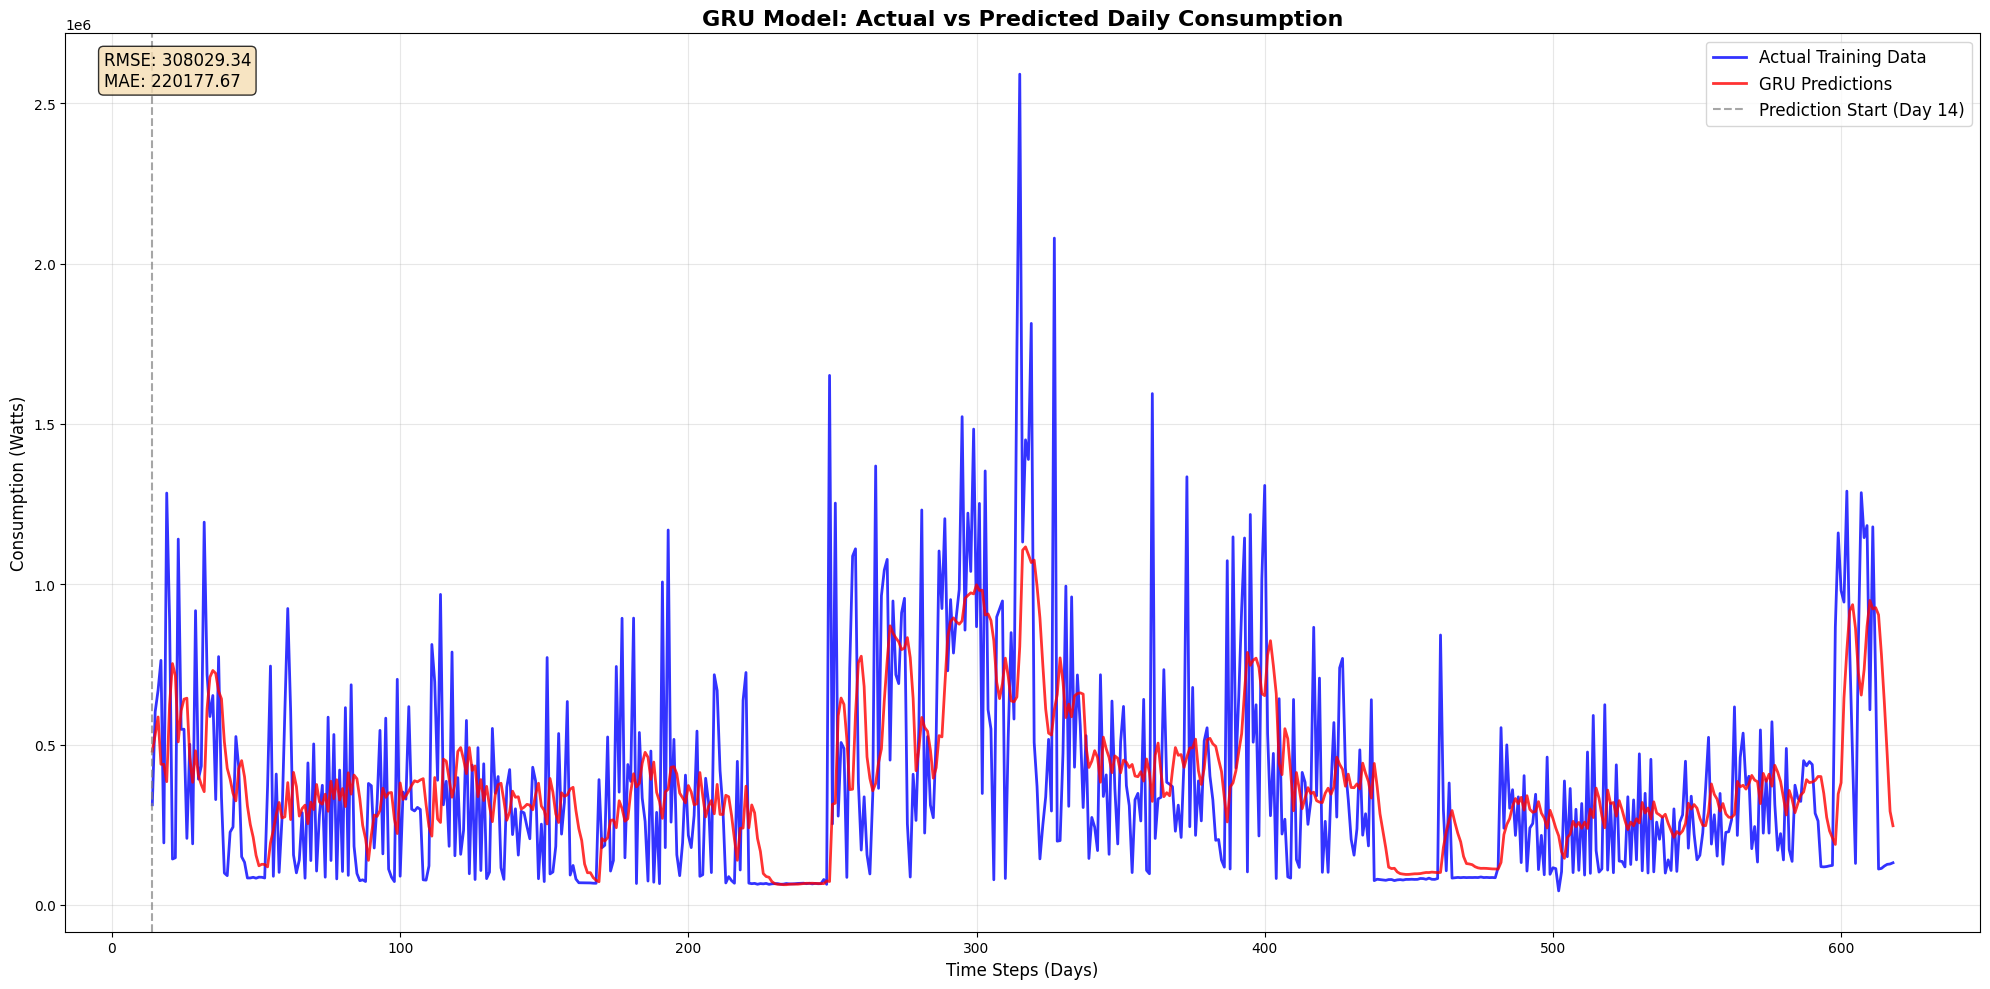


GRU MODEL PERFORMANCE METRICS
Training Data Points: 605
Time Steps Used: 14 days
RMSE: 308029.3359 Watts
MAE: 220177.6654 Watts
Mean Actual Consumption: 378720.7994 Watts
Mean Predicted Consumption: 392897.1250 Watts
R² Score: 0.2340


In [44]:
plt.figure(figsize=(20, 10))

# Calculate the correct starting index based on timestep
start_idx = timestep  # 30 days offset due to timestep

# Create proper time-aligned plots
# Actual values (offset by timestep)
actual_full = np.full(len(x), np.nan)
actual_full[start_idx:start_idx + len(actual)] = actual.flatten()

# Predicted values (offset by timestep)
predictions_full = np.full(len(x), np.nan)
predictions_full[start_idx:start_idx + len(train_predictions)] = train_predictions.flatten()

# Plot the data
plt.plot(actual_full, label='Actual Training Data', color='blue', linewidth=2, alpha=0.8)
plt.plot(predictions_full, label='GRU Predictions', color='red', linewidth=2, alpha=0.8)

# Add vertical line to show where predictions start
plt.axvline(x=start_idx, color='gray', linestyle='--', alpha=0.7, label=f'Prediction Start (Day {start_idx})')

# Formatting
plt.title('GRU Model: Actual vs Predicted Daily Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Consumption (Watts)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add performance metrics as text
rmse = np.sqrt(mean_squared_error(actual, train_predictions))
mae = np.mean(np.abs(actual - train_predictions))
plt.text(0.02, 0.98, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print(f"GRU MODEL PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Training Data Points: {len(actual)}")
print(f"Time Steps Used: {timestep} days")
print(f"RMSE: {rmse:.4f} Watts")
print(f"MAE: {mae:.4f} Watts")
print(f"Mean Actual Consumption: {np.mean(actual):.4f} Watts")
print(f"Mean Predicted Consumption: {np.mean(train_predictions):.4f} Watts")
print(f"R² Score: {1 - (np.sum((actual - train_predictions)**2) / np.sum((actual - np.mean(actual))**2)):.4f}")
print(f"{'='*60}")

## A day granularity forecast

In [137]:
timestep =7
X_train, y_train = create_dataset(train_data, timestep)
X_test, ytest = create_dataset(test_data, timestep)
X_val, yval = create_dataset(val_data, timestep)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (302, 7)
X_test shape:  (11, 7)
X_val shape:  (28, 7)


In [138]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (302, 7, 1)
X_test shape:  (11, 7, 1)
X_val shape:  (28, 7, 1)


In [139]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

# Optimized model for small dataset (203 samples)
model = Sequential()

# First GRU layer - reduced units to prevent overfitting
model.add(GRU(units=32, return_sequences=True, input_shape=(timestep, 1), 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second GRU layer - smaller
model.add(GRU(units=16, return_sequences=False, 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers - minimal complexity
model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Optimized optimizer with lower learning rate
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 7, 32)             3360      
                                                                 
 batch_normalization_10 (Bat  (None, 7, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 7, 32)             0         
                                                                 
 gru_38 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_11 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_46 (Dropout)        (None, 16)              

In [140]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 7, 32)             3360      
                                                                 
 batch_normalization_10 (Bat  (None, 7, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 7, 32)             0         
                                                                 
 gru_38 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_11 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_46 (Dropout)        (None, 16)              

In [141]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# More aggressive early stopping for small dataset
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience for small dataset
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Training with smaller batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, yval),
    epochs=100,  # More epochs for small dataset
    batch_size=16,  # Smaller batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
19/19 [==============================] - 3s 55ms/step - loss: 0.5044 - mae: 0.7210 - val_loss: 0.2234 - val_mae: 0.4084 - lr: 5.0000e-04
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 0.3933 - mae: 0.5936 - val_loss: 0.2206 - val_mae: 0.4071 - lr: 5.0000e-04
Epoch 3/100
19/19 [==============================] - 0s 14ms/step - loss: 0.4093 - mae: 0.6069 - val_loss: 0.2166 - val_mae: 0.4034 - lr: 5.0000e-04
Epoch 4/100
19/19 [==============================] - 0s 14ms/step - loss: 0.3526 - mae: 0.5463 - val_loss: 0.2012 - val_mae: 0.3813 - lr: 5.0000e-04
Epoch 5/100
19/19 [==============================] - 0s 14ms/step - loss: 0.3160 - mae: 0.4978 - val_loss: 0.1934 - val_mae: 0.3723 - lr: 5.0000e-04
Epoch 6/100
19/19 [==============================] - 0s 14ms/step - loss: 0.2908 - mae: 0.4758 - val_loss: 0.1881 - val_mae: 0.3663 - lr: 5.0000e-04
Epoch 7/100
19/19 [==============================] - 0s 13ms/step - loss: 0.2842 - mae: 0.4554 - val_loss:

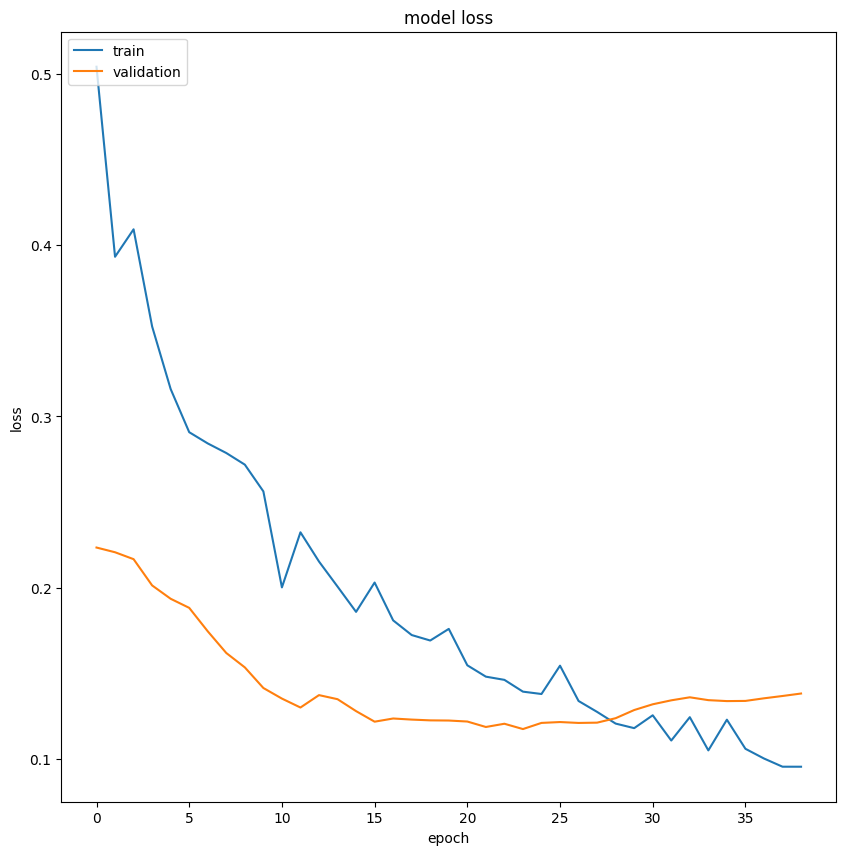

In [142]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [40]:
import tensorflow as tf
tf.__version__

'2.10.1'

In [143]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)


1/1 [==============================] - 0s 17ms/step


In [144]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [145]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.11428262941677908

In [146]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(302, 1)
(11, 1)
(28, 1)
[0.09784801]
(302,)


In [147]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

10/10 [==============================] - 0s 4ms/step


,Train Predictions,Actuals
0,[0.09784801304340363],[0.15755474032516822]
1,[0.031296052038669586],[0.2610770375243476]
2,[0.07524670660495758],[0.27025010944817995]
3,[0.16842259466648102],[0.18038501433987697]
4,[0.22885729372501373],[0.23221376823316664]
...,...,...
297,[0.27003055810928345],[0.4407002127715281]
298,[0.3076215088367462],[0.33233852382830165]
299,[0.33274829387664795],[0.1354745620954406]
300,[0.28259962797164917],[0.021212649416056297]


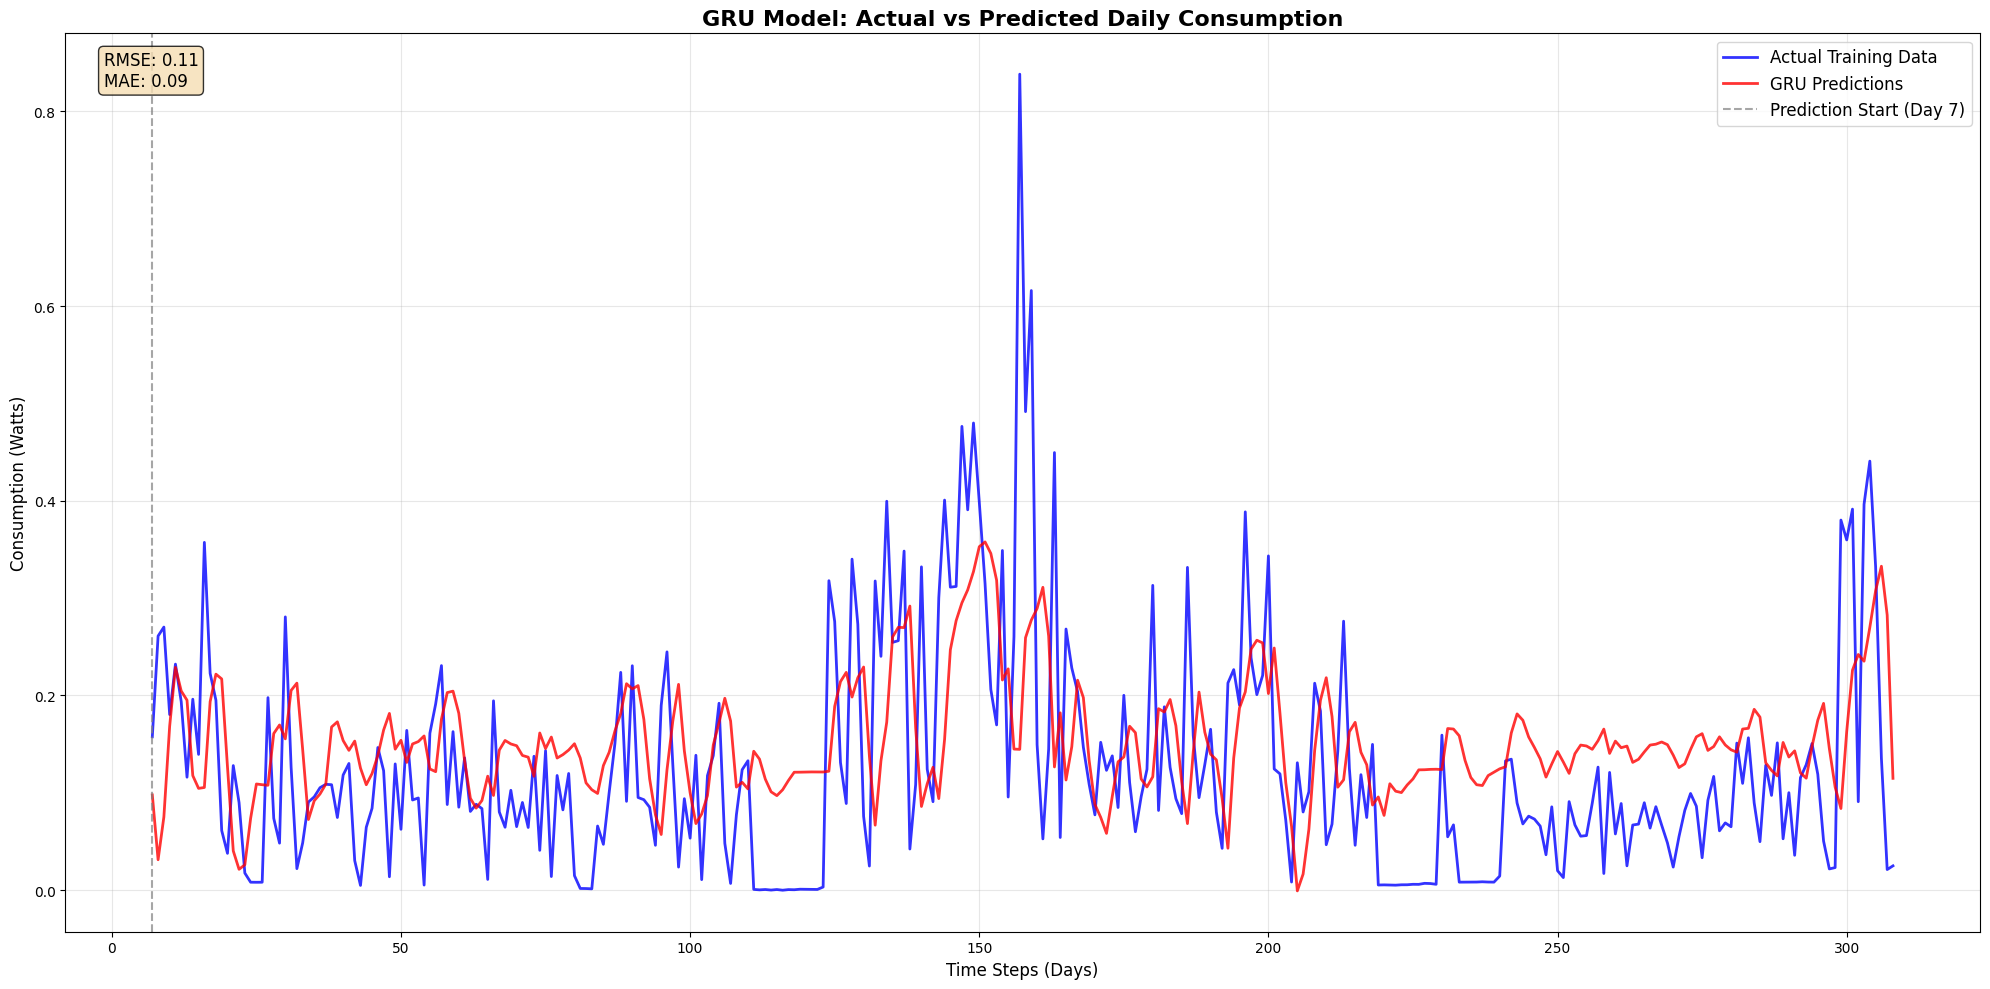


GRU MODEL PERFORMANCE METRICS
Training Data Points: 302
Time Steps Used: 7 days
RMSE: 0.1143 Watts
MAE: 0.0894 Watts
Mean Actual Consumption: 0.1263 Watts
Mean Predicted Consumption: 0.1520 Watts
R² Score: 0.0529


In [148]:
plt.figure(figsize=(20, 10))

# Calculate the correct starting index based on timestep
start_idx = timestep  # 30 days offset due to timestep

# Create proper time-aligned plots
# Actual values (offset by timestep)
actual_full = np.full(len(x), np.nan)
actual_full[start_idx:start_idx + len(actual)] = actual.flatten()

# Predicted values (offset by timestep)
predictions_full = np.full(len(x), np.nan)
predictions_full[start_idx:start_idx + len(train_predictions)] = train_predictions.flatten()

# Plot the data
plt.plot(actual_full, label='Actual Training Data', color='blue', linewidth=2, alpha=0.8)
plt.plot(predictions_full, label='GRU Predictions', color='red', linewidth=2, alpha=0.8)

# Add vertical line to show where predictions start
plt.axvline(x=start_idx, color='gray', linestyle='--', alpha=0.7, label=f'Prediction Start (Day {start_idx})')

# Formatting
plt.title('GRU Model: Actual vs Predicted Daily Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Consumption (Watts)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add performance metrics as text
rmse = np.sqrt(mean_squared_error(actual, train_predictions))
mae = np.mean(np.abs(actual - train_predictions))
plt.text(0.02, 0.98, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print(f"GRU MODEL PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Training Data Points: {len(actual)}")
print(f"Time Steps Used: {timestep} days")
print(f"RMSE: {rmse:.4f} Watts")
print(f"MAE: {mae:.4f} Watts")
print(f"Mean Actual Consumption: {np.mean(actual):.4f} Watts")
print(f"Mean Predicted Consumption: {np.mean(train_predictions):.4f} Watts")
print(f"R² Score: {1 - (np.sum((actual - train_predictions)**2) / np.sum((actual - np.mean(actual))**2)):.4f}")
print(f"{'='*60}")